In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 한글 폰트 설정
plt.rcParams.update({'font.family' : 'Malgun Gothic'}) # 맑은 고딕 설정
plt.rcParams.update({'axes.unicode_minus' : False}) # 음수 기호 깨짐 방지

In [2]:
# 데이터 불러오기
raw_building = pd.read_csv('../data/data_week2.csv', encoding='cp949')
train_chungju = pd.read_csv('../data/train_chungju_new.csv', encoding='utf-8')
test_chungju = pd.read_csv('../data/test_2020.csv', encoding='utf-8')

### 데이터 전처리, 파악

In [4]:
### 변수명 변경
building_df = raw_building.rename(columns={
    '전력사용량(kWh)': '전력사용량',
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조'
}, inplace=False)

train_SolarEnergy = train_chungju.rename(columns={
    '일시': 'date_time',
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조',
    '일사(MJ/m2)': '일사'
}, inplace=False)

test_SolarEnergy = test_chungju.rename(columns={
    '일시': 'date_time',
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조',
    '일사(MJ/m2)': '일사'
}, inplace=False)

print(building_df.columns) # 바뀐거 확인
print(train_SolarEnergy.columns)
print(test_SolarEnergy.columns)

Index(['num', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', '비전기냉방설비운영',
       '태양광보유'],
      dtype='object')
Index(['date_time', '기온', '강수량', '풍속', '습도', '일조', '일사'], dtype='object')
Index(['date_time', '기온', '강수량', '풍속', '습도', '일조', '일사'], dtype='object')


In [5]:
building_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [6]:
building_df.tail()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0
122399,60,2020-08-24 23,3204.576,27.1,2.6,75.0,0.0,0.0,1.0,1.0


In [7]:
building_df.shape

(122400, 10)

In [13]:
train_SolarEnergy.head()

,date_time,기온,강수량,풍속,습도,일조,일사
0,2017-01-01 00:00:00,2.4,NaN,0.5,78,NaN,NaN
1,2017-01-01 01:00:00,2.2,NaN,0.2,78,NaN,NaN
2,2017-01-01 02:00:00,1.9,NaN,0.5,80,NaN,NaN
3,2017-01-01 03:00:00,1.1,NaN,0.5,83,NaN,NaN
4,2017-01-01 04:00:00,1.0,NaN,0.0,84,NaN,NaN


In [15]:
train_SolarEnergy.shape

(29927, 7)

In [16]:
test_SolarEnergy.head()

,date_time,기온,강수량,풍속,습도,일조,일사
0,2020-06-01 00:00:00,20.7,0.0,0.8,65.0,NaN,NaN
1,2020-06-01 01:00:00,18.1,0.0,1.1,87.0,NaN,NaN
2,2020-06-01 02:00:00,18.0,0.1,0.8,91.0,NaN,NaN
3,2020-06-01 03:00:00,18.0,0.5,1.1,92.0,NaN,NaN
4,2020-06-01 04:00:00,18.2,0.0,1.1,91.0,NaN,NaN


In [17]:
test_SolarEnergy.shape

(2040, 7)

In [10]:
### 데이터 타입 변경
# 빌딩 데이터
building_df.info()
building_df["num"] = building_df["num"].astype("object") # num -> object 형식으로 변환
building_df['date_time'] = pd.to_datetime(building_df['date_time']) # date_time -> datetime 형식으로 변환
building_df[["비전기냉방설비운영", "태양광보유"]] = building_df[["비전기냉방설비운영", "태양광보유"]].astype("bool") # 비전기냉방설비운영, 태양광보유 -> bool 값으로 변경
print(building_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   num        122400 non-null  object        
 1   date_time  122400 non-null  datetime64[ns]
 2   전력사용량      122400 non-null  float64       
 3   기온         122400 non-null  float64       
 4   풍속         122400 non-null  float64       
 5   습도         122400 non-null  float64       
 6   강수량        122400 non-null  float64       
 7   일조         122400 non-null  float64       
 8   비전기냉방설비운영  122400 non-null  bool          
 9   태양광보유      122400 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(6), object(1)
memory usage: 7.7+ MB
num                  object
date_time    datetime64[ns]
전력사용량               float64
기온                  float64
풍속                  float64
습도                  float64
강수량                 float64
일조                  float64
비전기냉방설비운영

In [11]:
# 청주 train 데이터
train_SolarEnergy.info()
train_SolarEnergy['date_time'] = pd.to_datetime(train_SolarEnergy['date_time']) # datetime 형식으로 변환
print(train_SolarEnergy.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29927 entries, 0 to 29926
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  29927 non-null  datetime64[ns]
 1   기온         29927 non-null  float64       
 2   강수량        2702 non-null   float64       
 3   풍속         29926 non-null  float64       
 4   습도         29927 non-null  int64         
 5   일조         16352 non-null  float64       
 6   일사         16345 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.6 MB
date_time    datetime64[ns]
기온                  float64
강수량                 float64
풍속                  float64
습도                    int64
일조                  float64
일사                  float64
dtype: object


In [12]:
# 청주 test 데이터
test_SolarEnergy.info()
test_SolarEnergy['date_time'] = pd.to_datetime(test_SolarEnergy['date_time']) # datetime 형식으로 변환
print(test_SolarEnergy.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  2040 non-null   datetime64[ns]
 1   기온         2040 non-null   float64       
 2   강수량        518 non-null    float64       
 3   풍속         2040 non-null   float64       
 4   습도         2038 non-null   float64       
 5   일조         1275 non-null   float64       
 6   일사         1275 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 111.7 KB
date_time    datetime64[ns]
기온                  float64
강수량                 float64
풍속                  float64
습도                  float64
일조                  float64
일사                  float64
dtype: object


In [18]:
building_df.describe()

,date_time,전력사용량,기온,풍속,습도,강수량,일조
count,122400,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,2020-07-13 11:30:00.000000256,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533
min,2020-06-01 00:00:00,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000
25%,2020-06-22 05:45:00,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000
50%,2020-07-13 11:30:00,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000
75%,2020-08-03 17:15:00,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000
max,2020-08-24 23:00:00,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000
std,NaN,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517


In [19]:
train_SolarEnergy.describe()

,date_time,기온,강수량,풍속,습도,일조,일사
count,29927,29927.000000,2702.000000,29926.000000,29927.000000,16352.000000,16345.000000
mean,2018-09-16 11:55:31.626958848,13.213246,1.394523,1.528106,59.238514,0.542191,1.122335
min,2017-01-01 00:00:00,-15.600000,0.000000,0.000000,10.000000,0.000000,0.000000
25%,2017-11-08 18:30:00,4.100000,0.000000,0.800000,44.000000,0.000000,0.240000
50%,2018-09-16 12:00:00,13.600000,0.100000,1.400000,60.000000,0.700000,0.910000
75%,2019-07-25 05:30:00,22.300000,1.200000,2.100000,75.000000,1.000000,1.830000
max,2020-05-31 23:00:00,38.100000,86.200000,7.700000,100.000000,1.000000,3.800000
std,NaN,10.784507,4.277216,0.972506,19.682066,0.447674,0.972006


In [20]:
test_SolarEnergy.describe()

,date_time,기온,강수량,풍속,습도,일조,일사
count,2040,2040.000000,518.000000,2040.000000,2038.000000,1275.000000,1275.000000
mean,2020-07-13 11:30:00,25.223775,1.590347,1.470245,73.354269,0.324941,1.128447
min,2020-06-01 00:00:00,15.900000,0.000000,0.000000,19.000000,0.000000,0.040000
25%,2020-06-22 05:45:00,22.700000,0.000000,0.900000,63.000000,0.000000,0.260000
50%,2020-07-13 11:30:00,25.100000,0.100000,1.400000,76.000000,0.000000,0.770000
75%,2020-08-03 17:15:00,27.500000,1.375000,1.900000,86.000000,0.800000,1.810000
max,2020-08-24 23:00:00,34.000000,34.200000,5.200000,96.000000,1.000000,3.860000
std,NaN,3.413885,3.495859,0.803219,14.982304,0.410045,1.025027


In [21]:
# 월, 일, 시를 각각 새로운 열로 추가
building_df['월'] = building_df['date_time'].dt.month
building_df['일'] = building_df['date_time'].dt.day
building_df['시'] = building_df['date_time'].dt.hour

# 요일 컬럼 추가 (월요일, 화요일, ...)
building_df['요일'] = building_df['date_time'].dt.day_name()

# 주말, 평일(토, 일) 추가
building_df = building_df.assign(주말or평일 = np.where(building_df['요일'] == ('Saturday' or 'Sunday'), 'weekend', 'weekday'))

In [22]:
building_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,월,일,시,요일,주말or평일
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,False,False,6,1,0,Monday,weekday
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,False,False,6,1,1,Monday,weekday
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,False,False,6,1,2,Monday,weekday
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,False,False,6,1,3,Monday,weekday
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,False,False,6,1,4,Monday,weekday


## EDA

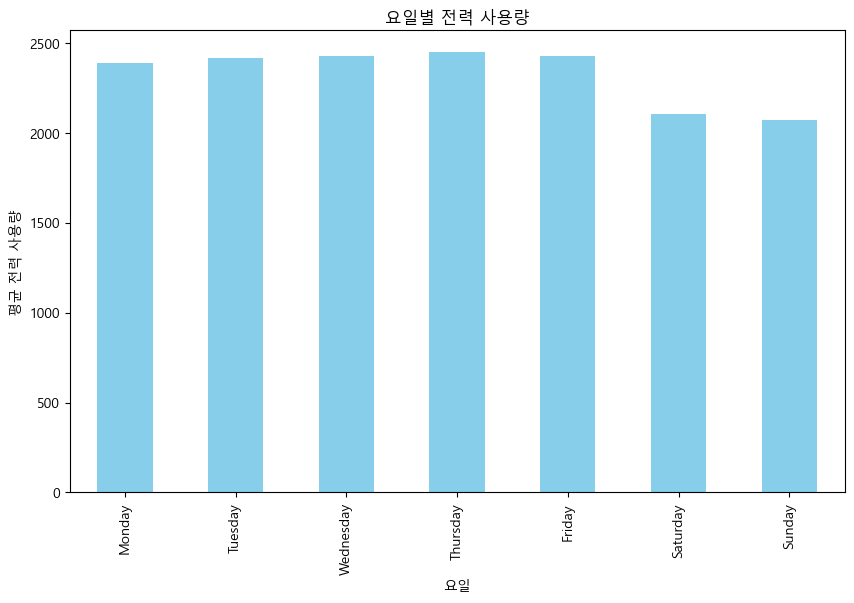

In [176]:
# 요일별 전력사용량
day7_electronic = building_df.groupby('요일')['전력사용량'].mean()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day7_electronic = day7_electronic.reindex(days_order)

day7_electronic.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('요일별 전력 사용량')
plt.ylabel('평균 전력 사용량')
plt.xlabel('요일')
plt.show()

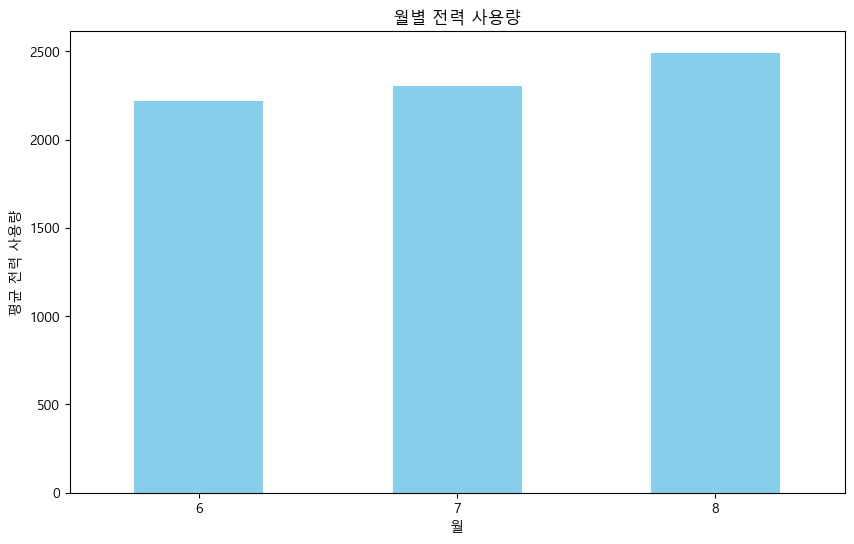

In [23]:
# 월별 전력사용량
month_electronic = building_df.groupby('월')['전력사용량'].mean()

month_electronic.plot(kind='bar', figsize=(10, 6), color='skyblue')

plt.xticks(rotation=0)
plt.title('월별 전력 사용량')
plt.ylabel('평균 전력 사용량')
plt.show()

11.1 36.3


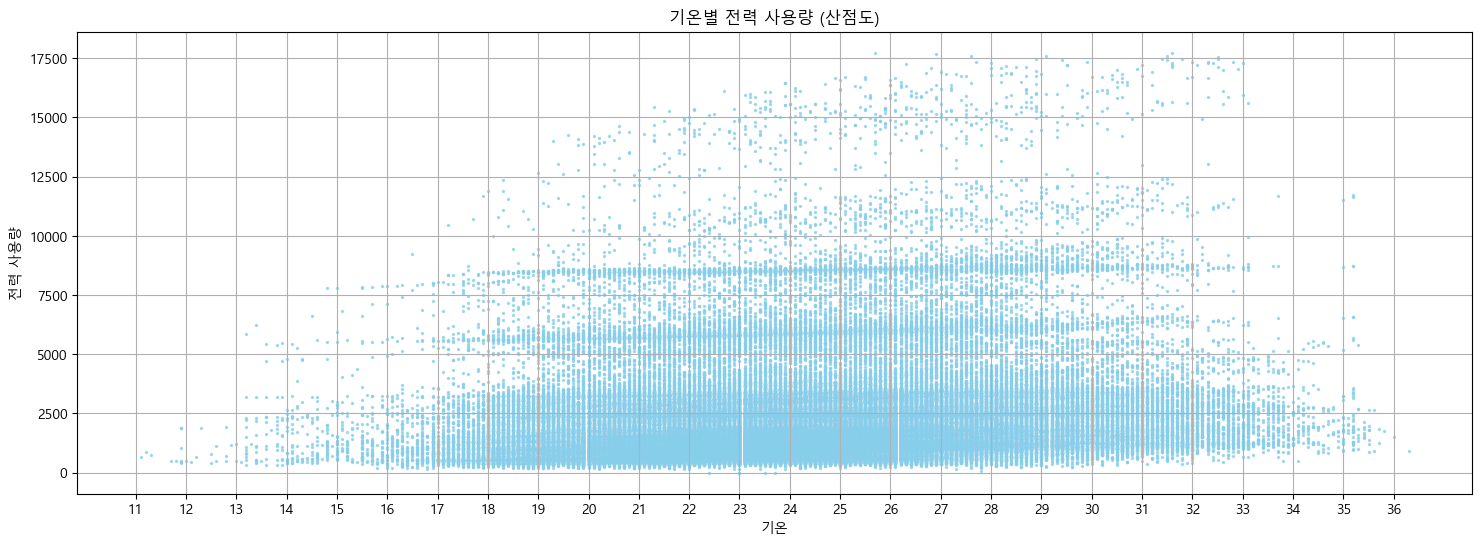

In [24]:
# 기온별 전력사용량
print(building_df["기온"].min(), building_df["기온"].max())

plt.figure(figsize=(18, 6))
plt.scatter(building_df['기온'], building_df['전력사용량'], color='skyblue', alpha=0.7, s=2)

plt.title('기온별 전력 사용량 (산점도)')
plt.xlabel('기온')
plt.ylabel('전력 사용량')
plt.xticks(range(int(building_df['기온'].min()), int(building_df['기온'].max()) + 1))  # 기온 범위에 맞게 x축 설정
plt.grid(True)  # 그리드 추가
plt.show()

0.0 20.1


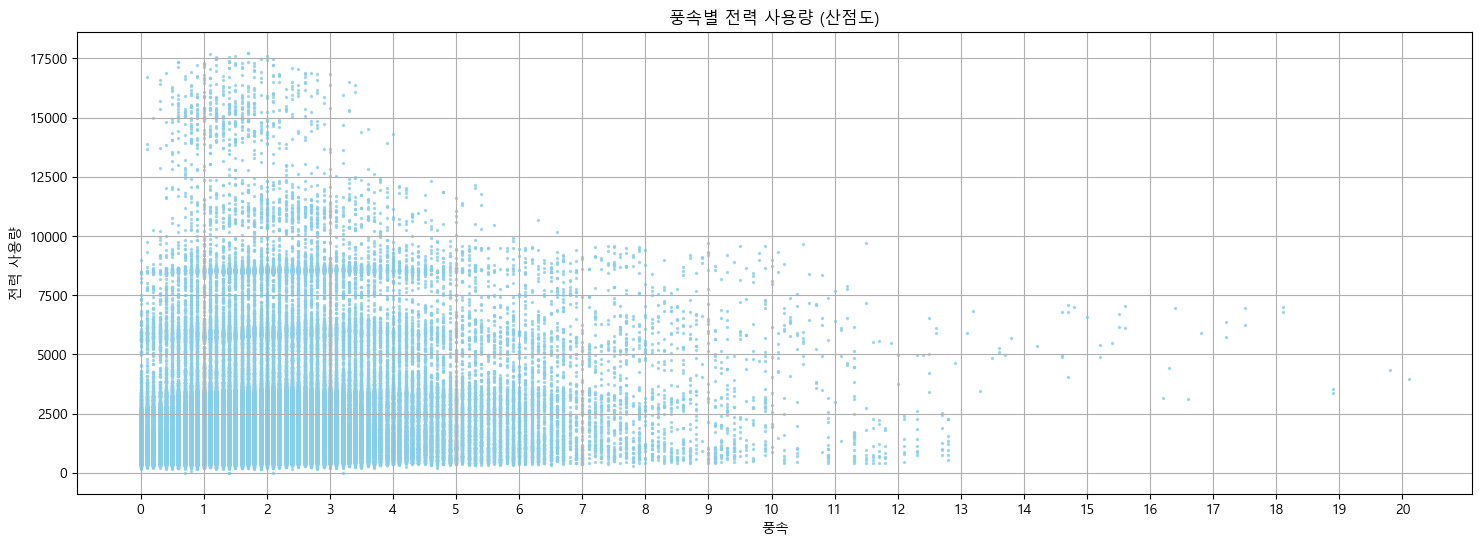

In [25]:
# 풍속별 전력사용량
print(building_df["풍속"].min(), building_df["풍속"].max())

plt.figure(figsize=(18, 6))
plt.scatter(building_df['풍속'], building_df['전력사용량'], color='skyblue', alpha=0.7, s=2)

plt.title('풍속별 전력 사용량 (산점도)')
plt.xlabel('풍속')
plt.ylabel('전력 사용량')
plt.xticks(range(int(building_df['풍속'].min()), int(building_df['풍속'].max()) + 1))  # 풍속 범위에 맞게 x축 설정
plt.grid(True)  # 그리드 추가
plt.show()

19.0 100.0


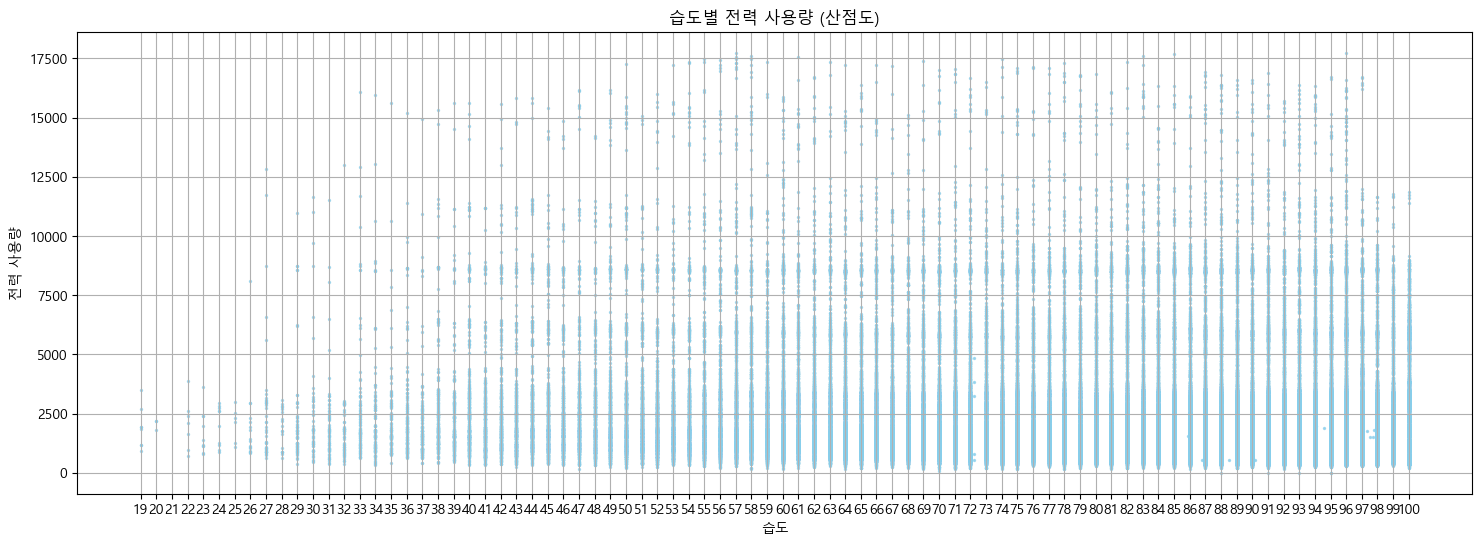

In [26]:
# 습도별 전력사용량
print(building_df["습도"].min(), building_df["습도"].max())

plt.figure(figsize=(18, 6))
plt.scatter(building_df['습도'], building_df['전력사용량'], color='skyblue', alpha=0.7, s=2)

plt.title('습도별 전력 사용량 (산점도)')
plt.xlabel('습도')
plt.ylabel('전력 사용량')
plt.xticks(range(int(building_df['습도'].min()), int(building_df['습도'].max()) + 1))  # 습도 범위에 맞게 x축 설정
plt.grid(True)  # 그리드 추가
plt.show()

0.0 81.5


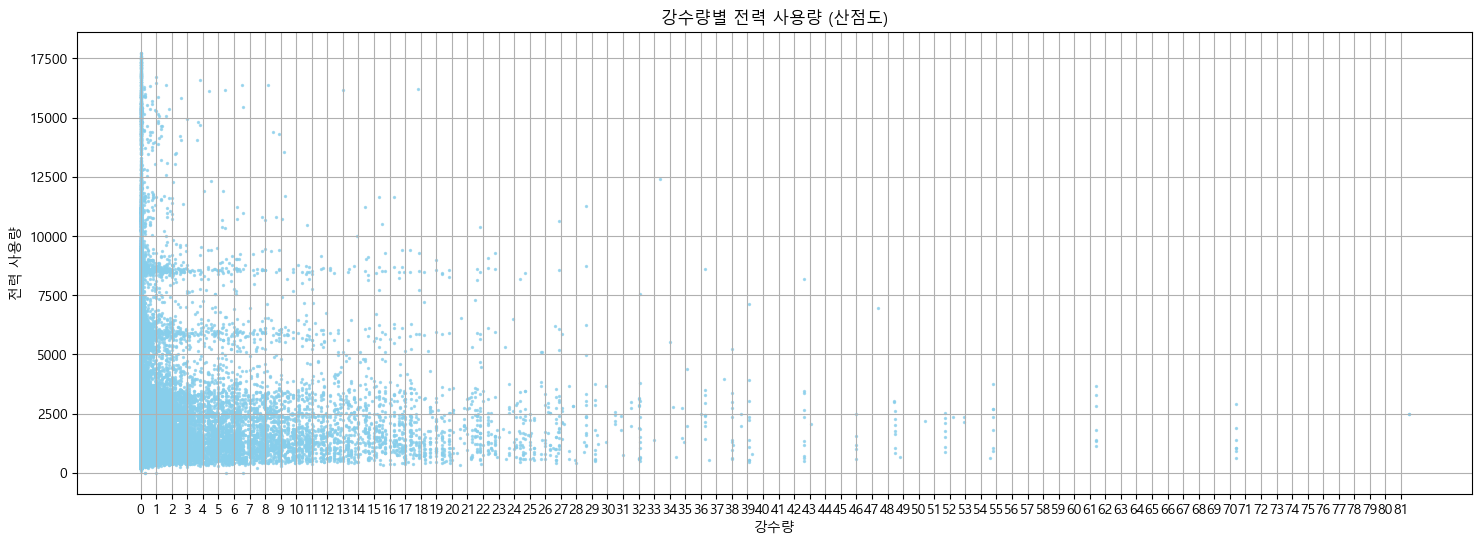

In [27]:
# 강수량별 전력사용량
print(building_df["강수량"].min(), building_df["강수량"].max())

plt.figure(figsize=(18, 6))
plt.scatter(building_df['강수량'], building_df['전력사용량'], color='skyblue', alpha=0.7, s=2)

plt.title('강수량별 전력 사용량 (산점도)')
plt.xlabel('강수량')
plt.ylabel('전력 사용량')
plt.xticks(range(int(building_df['강수량'].min()), int(building_df['강수량'].max()) + 1))  # 강수량 범위에 맞게 x축 설정
plt.grid(True)  # 그리드 추가
plt.show()

0.0 1.0


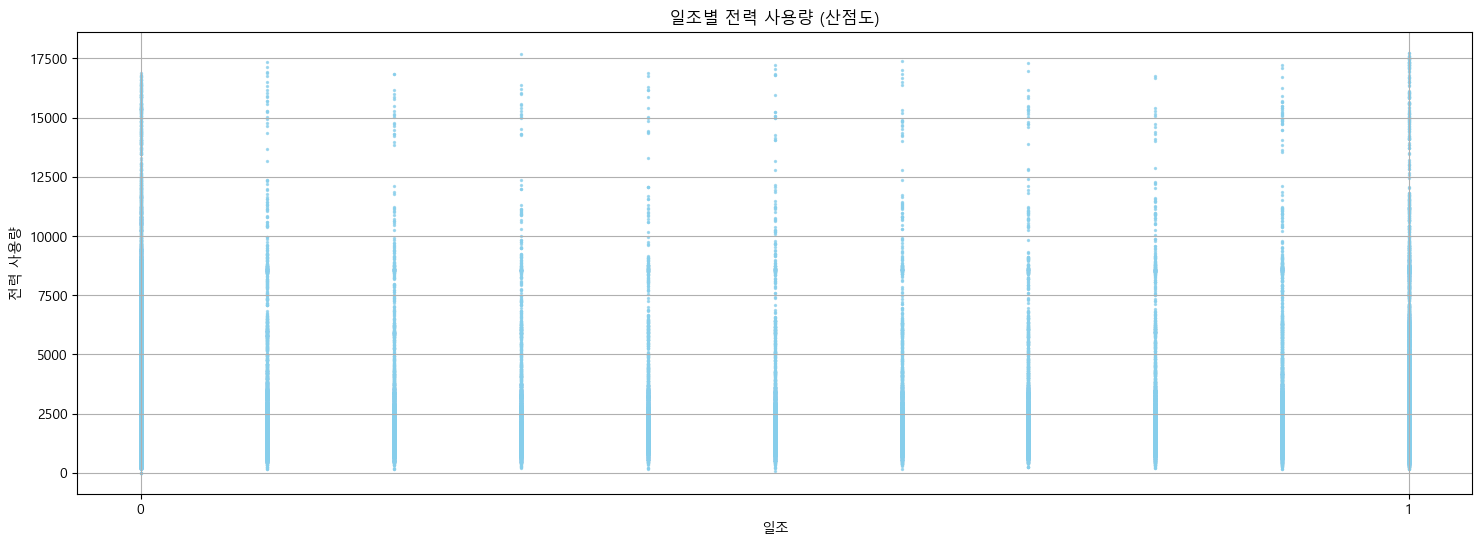

In [28]:
# 일조별 전력사용량
print(building_df["일조"].min(), building_df["일조"].max())

plt.figure(figsize=(18, 6))
plt.scatter(building_df['일조'], building_df['전력사용량'], color='skyblue', alpha=0.7, s=2)

plt.title('일조별 전력 사용량 (산점도)')
plt.xlabel('일조')
plt.ylabel('전력 사용량')
plt.xticks(range(int(building_df['일조'].min()), int(building_df['일조'].max()) + 1))  # 일조 범위에 맞게 x축 설정
plt.grid(True)  # 그리드 추가
plt.show()

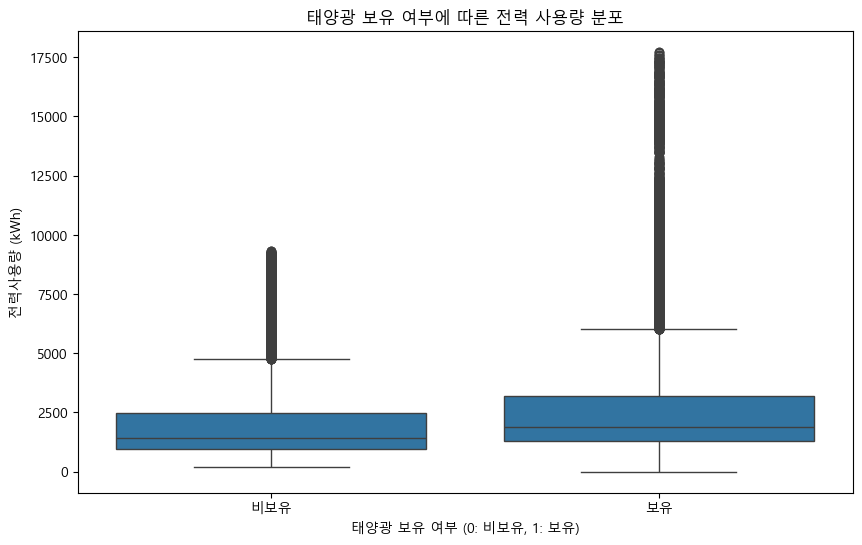

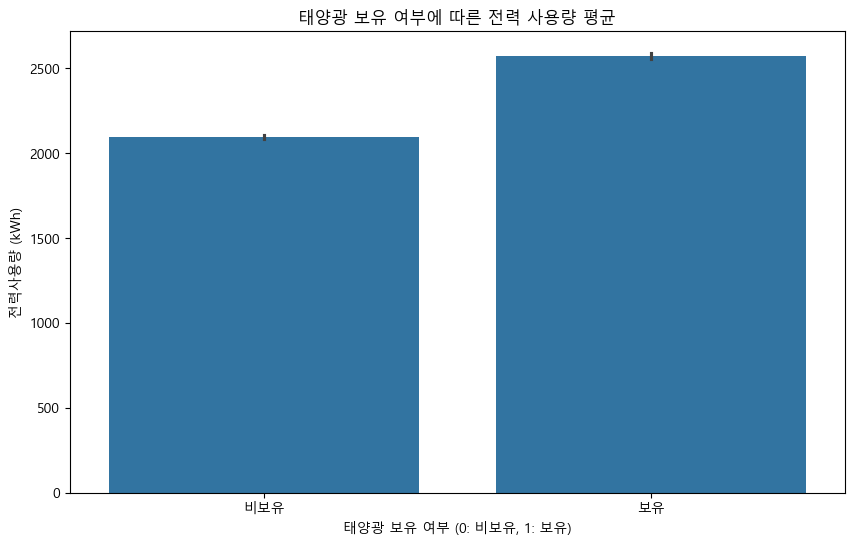

In [29]:
# 태양광 보유 유무에 따른 전력사용량
# Boxplot 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='태양광보유', y='전력사용량', data=building_df)
plt.xticks([0, 1], ['비보유', '보유'], rotation=0)
plt.title('태양광 보유 여부에 따른 전력 사용량 분포')
plt.xlabel('태양광 보유 여부 (0: 비보유, 1: 보유)')
plt.ylabel('전력사용량 (kWh)')
plt.show()

# Bar plot 시각화 (평균값)
plt.figure(figsize=(10, 6))
sns.barplot(x='태양광보유', y='전력사용량', data=building_df)
plt.xticks([0, 1], ['비보유', '보유'], rotation=0)
plt.title('태양광 보유 여부에 따른 전력 사용량 평균')
plt.xlabel('태양광 보유 여부 (0: 비보유, 1: 보유)')
plt.ylabel('전력사용량 (kWh)')
plt.show()

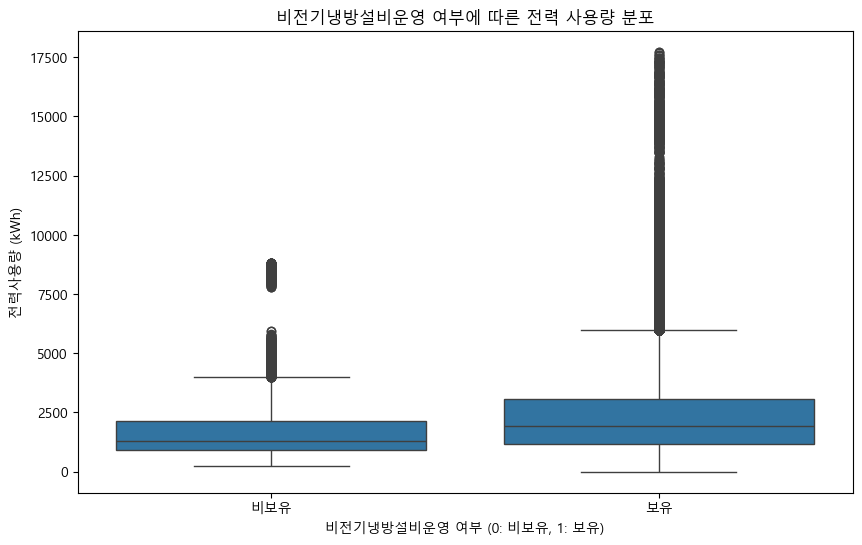

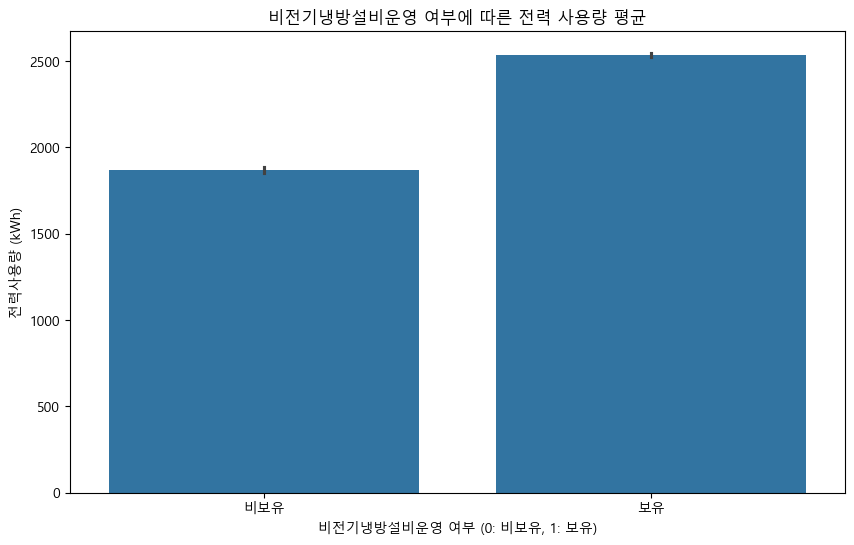

In [30]:
# 비전기냉방설비운영 여부에 따른 전력사용량 평균
# Boxplot 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='비전기냉방설비운영', y='전력사용량', data=building_df)
plt.xticks([0, 1], ['비보유', '보유'], rotation=0)
plt.title('비전기냉방설비운영 여부에 따른 전력 사용량 분포')
plt.xlabel('비전기냉방설비운영 여부 (0: 비보유, 1: 보유)')
plt.ylabel('전력사용량 (kWh)')
plt.show()

# Bar plot 시각화 (평균값)
plt.figure(figsize=(10, 6))
sns.barplot(x='비전기냉방설비운영', y='전력사용량', data=building_df)
plt.xticks([0, 1], ['비보유', '보유'], rotation=0)
plt.title('비전기냉방설비운영 여부에 따른 전력 사용량 평균')
plt.xlabel('비전기냉방설비운영 여부 (0: 비보유, 1: 보유)')
plt.ylabel('전력사용량 (kWh)')
plt.show()

### 태양광 유무에 따른 EDA